In [1]:
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf
!pip install mujoco
!pip install gymnasium[mujoco]
!mkdir -p ~/.mujoco
!wget https://mujoco.org/download/mujoco210-linux-`x86_64.tar.gz -O mujoco.tar.gz
!tar -xvzf mujoco.tar.gz -C ~/.mujoco
!rm mujoco.tar.gz
!wget https://roboti.us/file/mjkey.txt -O ~/.mujoco/mjkey.txt
!pip install imageio[ffmpeg]
!pip install omegaconf

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,088 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB

In [2]:
import os
os.environ['LD_LIBRARY_PATH'] += ':/root/.mujoco/mujoco210/bin'
os.environ['MUJOCO_GL'] = 'egl'

import copy
import random
import collections

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

from omegaconf import OmegaConf

from IPython.display import Video, display

In [3]:
def record_video(env, agent, video_folder):
    state, _ = env.reset()
    terminated, truncated = False, False
    total_reward = 0

    while not (terminated or truncated):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.config.device)
        with torch.no_grad():
            agent.actor.eval()  # 평가 모드로 전환
            action = agent.actor(state_tensor).cpu().detach().numpy().squeeze(0)
            agent.actor.train()  # 학습 모드로 전환

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state

    env.close()
    return total_reward

In [11]:
env = gym.make('Hopper-v4', render_mode='rgb_array')
AC_config = OmegaConf.create({
    # RL parameter
    'gamma': 0.99,

    # replay memory
    'buffer_limit': int(1e6),
    'batch_size': 256,  # larger batch size for more stable updates

    # neural network parameters
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    #'hidden_dim': 256,  # larger hidden layer for more complex policy representation
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]),  # cannot use .n because actions are continuous!

    # learning parameters
    'lr_actor': 0.0004,  # lower learning rate for more stable updates
    'lr_critic': 0.0004,
    'tau': 0.005,  # soft update parameter

    # noise parameters
    'exploration_theta': 0.15,
    'exploration_sigma': 0.075,
    'policy_theta': 0.15,
    'policy_sigma': 0.075,
    'dt': 0.01,

    # TD3 specific parameters
    'policy_delay': 2,
})

In [12]:
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.buffer = collections.deque(maxlen=self.config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, next_s_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            next_s_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(a_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(r_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(next_s_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(done_mask_lst, dtype=torch.float32).to(self.config.device)
        )
    def size(self):
        return len(self.buffer)

In [13]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu, theta, sigma, dt):
        self.theta = theta
        self.sigma = sigma
        self.dt = dt
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

In [14]:
def soft_update(net, net_target, tau):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [15]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.layer_1 = nn.Linear(state_dim + action_dim, 256)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_3 = nn.Linear(256, 1)

        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(state_dim + action_dim, 256)
        self.layer_5 = nn.Linear(256, 256)
        self.layer_6 = nn.Linear(256, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)

        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)

        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

In [16]:
class ActorCritic(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.memory = ReplayBuffer(self.config)
        self.exploration_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim), theta=self.config.exploration_theta, sigma=self.config.exploration_sigma, dt=self.config.dt)
        self.policy_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim), theta=self.config.policy_theta, sigma=self.config.policy_sigma, dt=self.config.dt)
        self.max_action = env.action_space.high[0]

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(self.config.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.config.action_dim),
            nn.Tanh()
        ).to(self.config.device)

        # Single Critic network with two outputs
        self.critic = Critic(self.config.state_dim, self.config.action_dim).to(self.config.device)

        # Target networks
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=self.config.lr_actor)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.config.lr_critic)

        self.total_it = 0

    def update(self):
        if self.memory.size() < self.config.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.config.batch_size)

        with torch.no_grad():
            noise = torch.tensor(self.policy_noise(), device=self.config.device, dtype=torch.float32)
            noise = torch.clamp(noise, -0.5, 0.5)
            next_actions = self.actor_target(next_states) + noise
            next_actions = torch.clamp(next_actions, -self.max_action, self.max_action)
            target_q1, target_q2 = self.critic_target(next_states, next_actions)
            target_q = rewards + dones * self.config.gamma * torch.min(target_q1, target_q2)

        current_q1, current_q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        if self.total_it % self.config.policy_delay == 0:
            actor_loss = -self.critic.Q1(states, self.actor(states)).mean()
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            soft_update(self.actor, self.actor_target, self.config.tau)
            soft_update(self.critic, self.critic_target, self.config.tau)
        self.total_it += 1

In [17]:
env = gym.make('Hopper-v4', render_mode='rgb_array')
num_epis = 6000
total_run = 0
epi_rews = []
agent = ActorCritic(AC_config)

eval_interval = 100  # 평가 간격
eval_rews = []

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0

    while not (terminated or truncated):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.config.device)
        with torch.no_grad():
            agent.actor.eval()
            action = agent.actor(state_tensor).cpu().detach().numpy().squeeze(0)
            agent.actor.train()
        noise = agent.exploration_noise()
        noise = np.clip(noise, -0.5, 0.5)
        action += noise
        action = np.clip(action, -agent.max_action, agent.max_action)
        next_state, reward, terminated, truncated, _ = env.step(action)

        agent.memory.put((state, action, reward, next_state, terminated or truncated))

        state = next_state
        epi_rew += reward
        total_run += 1

        if total_run > 25000:
            agent.update()

    epi_rews.append(epi_rew)

    if (n_epi + 1) % eval_interval == 0:
        avg_rew = np.mean(epi_rews[-eval_interval:])
        print(f"Episode {n_epi + 1}: Average Reward: {avg_rew}", f"Total Steps {total_run}, Total Updates {agent.total_it}")
        eval_rews.append(avg_rew)

    if total_run > int(1e6):
        print(f"Total Step {total_run} Exceeded {int(1e6)}")
        break

env.close()

  2%|▏         | 107/6000 [00:01<01:17, 75.94it/s]

Episode 100: Average Reward: 14.480807112044754 Total Steps 1938, Total Updates 0


  4%|▎         | 213/6000 [00:03<01:24, 68.30it/s]

Episode 200: Average Reward: 21.831174687648108 Total Steps 4445, Total Updates 0


  5%|▌         | 319/6000 [00:05<01:00, 93.48it/s]

Episode 300: Average Reward: 9.423688406975431 Total Steps 6090, Total Updates 0


  7%|▋         | 412/6000 [00:06<01:16, 73.12it/s]

Episode 400: Average Reward: 13.554744038418415 Total Steps 7552, Total Updates 0


  8%|▊         | 506/6000 [00:09<02:20, 39.12it/s]

Episode 500: Average Reward: 31.99845957406279 Total Steps 10862, Total Updates 0


 10%|█         | 615/6000 [00:11<01:17, 69.42it/s]

Episode 600: Average Reward: 21.347289798334387 Total Steps 13765, Total Updates 0


 12%|█▏        | 711/6000 [00:12<00:50, 105.12it/s]

Episode 700: Average Reward: 8.12298380509969 Total Steps 14895, Total Updates 0


 13%|█▎        | 805/6000 [00:13<00:55, 93.42it/s]

Episode 800: Average Reward: 10.504727738968207 Total Steps 16270, Total Updates 0


 15%|█▌        | 905/6000 [00:14<01:31, 55.90it/s]

Episode 900: Average Reward: 14.919777502943493 Total Steps 18091, Total Updates 0


 17%|█▋        | 1017/6000 [00:16<00:49, 99.82it/s]

Episode 1000: Average Reward: 12.179627884228546 Total Steps 19495, Total Updates 0


 19%|█▊        | 1111/6000 [00:17<01:05, 74.26it/s]

Episode 1100: Average Reward: 12.687179841745092 Total Steps 21257, Total Updates 0


 20%|██        | 1207/6000 [00:18<01:05, 73.49it/s]

Episode 1200: Average Reward: 12.900181938045161 Total Steps 22959, Total Updates 0


 22%|██▏       | 1302/6000 [00:21<04:49, 16.24it/s]

Episode 1300: Average Reward: 16.49464897756278 Total Steps 25154, Total Updates 154


 23%|██▎       | 1401/6000 [00:41<48:35,  1.58it/s]  

Episode 1400: Average Reward: 40.34262377629413 Total Steps 27712, Total Updates 2712


 25%|██▌       | 1500/6000 [01:17<46:47,  1.60it/s]

Episode 1500: Average Reward: 84.93309976372011 Total Steps 32470, Total Updates 7470


 27%|██▋       | 1600/6000 [02:11<48:37,  1.51it/s]

Episode 1600: Average Reward: 134.42009159840524 Total Steps 39425, Total Updates 14425


 28%|██▊       | 1700/6000 [03:18<52:24,  1.37it/s]

Episode 1700: Average Reward: 172.7581713539722 Total Steps 47996, Total Updates 22996


 30%|███       | 1800/6000 [04:28<53:42,  1.30it/s]

Episode 1800: Average Reward: 187.52742985757112 Total Steps 56864, Total Updates 31864


 32%|███▏      | 1900/6000 [05:46<52:07,  1.31it/s]

Episode 1900: Average Reward: 219.41687703225202 Total Steps 66559, Total Updates 41559


 33%|███▎      | 2000/6000 [08:46<1:12:28,  1.09s/it]

Episode 2000: Average Reward: 344.84118264719757 Total Steps 88263, Total Updates 63263


 35%|███▌      | 2100/6000 [11:56<1:10:59,  1.09s/it]

Episode 2100: Average Reward: 356.5986881943969 Total Steps 110300, Total Updates 85300


 37%|███▋      | 2200/6000 [13:54<1:16:50,  1.21s/it]

Episode 2200: Average Reward: 272.25713811357923 Total Steps 123422, Total Updates 98422


 38%|███▊      | 2300/6000 [16:10<1:24:07,  1.36s/it]

Episode 2300: Average Reward: 346.98611315527074 Total Steps 138169, Total Updates 113169


 40%|████      | 2400/6000 [19:16<1:32:36,  1.54s/it]

Episode 2400: Average Reward: 387.318925257483 Total Steps 157631, Total Updates 132631


 42%|████▏     | 2500/6000 [21:57<1:42:06,  1.75s/it]

Episode 2500: Average Reward: 371.39793233619974 Total Steps 173528, Total Updates 148528


 43%|████▎     | 2600/6000 [24:57<1:35:44,  1.69s/it]

Episode 2600: Average Reward: 440.65410619036476 Total Steps 190694, Total Updates 165694


 45%|████▌     | 2700/6000 [27:44<1:36:32,  1.76s/it]

Episode 2700: Average Reward: 461.9798592517658 Total Steps 207473, Total Updates 182473


 47%|████▋     | 2800/6000 [31:45<1:48:49,  2.04s/it]

Episode 2800: Average Reward: 652.7716161681439 Total Steps 230719, Total Updates 205719


 48%|████▊     | 2900/6000 [36:48<1:27:53,  1.70s/it]

Episode 2900: Average Reward: 832.521512732309 Total Steps 258186, Total Updates 233186


 50%|█████     | 3000/6000 [41:24<2:26:00,  2.92s/it]

Episode 3000: Average Reward: 712.8485793014364 Total Steps 281805, Total Updates 256805


 52%|█████▏    | 3100/6000 [46:43<3:07:26,  3.88s/it]

Episode 3100: Average Reward: 809.6731924881705 Total Steps 307998, Total Updates 282998


 53%|█████▎    | 3200/6000 [57:47<4:46:24,  6.14s/it]

Episode 3200: Average Reward: 1529.7565388918918 Total Steps 355948, Total Updates 330948


 55%|█████▌    | 3300/6000 [1:11:24<10:17:38, 13.73s/it]

Episode 3300: Average Reward: 1686.9283390238413 Total Steps 407981, Total Updates 382981


 57%|█████▋    | 3400/6000 [1:25:44<6:02:49,  8.37s/it]

Episode 3400: Average Reward: 1804.0958464230816 Total Steps 463080, Total Updates 438080


 58%|█████▊    | 3500/6000 [1:38:26<4:20:47,  6.26s/it]

Episode 3500: Average Reward: 1544.6778228869268 Total Steps 509695, Total Updates 484695


 60%|██████    | 3600/6000 [1:52:02<5:47:15,  8.68s/it]

Episode 3600: Average Reward: 1551.8194523245 Total Steps 556315, Total Updates 531315


 62%|██████▏   | 3700/6000 [2:08:42<4:58:53,  7.80s/it]

Episode 3700: Average Reward: 1771.4045028264948 Total Steps 609369, Total Updates 584369


 63%|██████▎   | 3800/6000 [2:26:56<8:09:25, 13.35s/it]

Episode 3800: Average Reward: 1798.07503225069 Total Steps 662423, Total Updates 637423


 65%|██████▌   | 3900/6000 [2:49:46<10:52:24, 18.64s/it]

Episode 3900: Average Reward: 2037.4560196881982 Total Steps 723073, Total Updates 698073


 67%|██████▋   | 4000/6000 [3:21:17<13:30:48, 24.32s/it]

Episode 4000: Average Reward: 2525.965911692145 Total Steps 797509, Total Updates 772509


 68%|██████▊   | 4100/6000 [3:46:51<11:45:24, 22.28s/it]

Episode 4100: Average Reward: 1833.596013832811 Total Steps 852044, Total Updates 827044


 70%|███████   | 4200/6000 [4:15:53<12:00:22, 24.01s/it]

Episode 4200: Average Reward: 1912.7825497836798 Total Steps 909191, Total Updates 884191


 72%|███████▏  | 4300/6000 [4:54:31<10:21:11, 21.92s/it]

Episode 4300: Average Reward: 2337.7307592979037 Total Steps 978322, Total Updates 953322


 72%|███████▏  | 4337/6000 [5:07:45<1:58:00,  4.26s/it]

Total Step 1000037 Exceeded 1000000


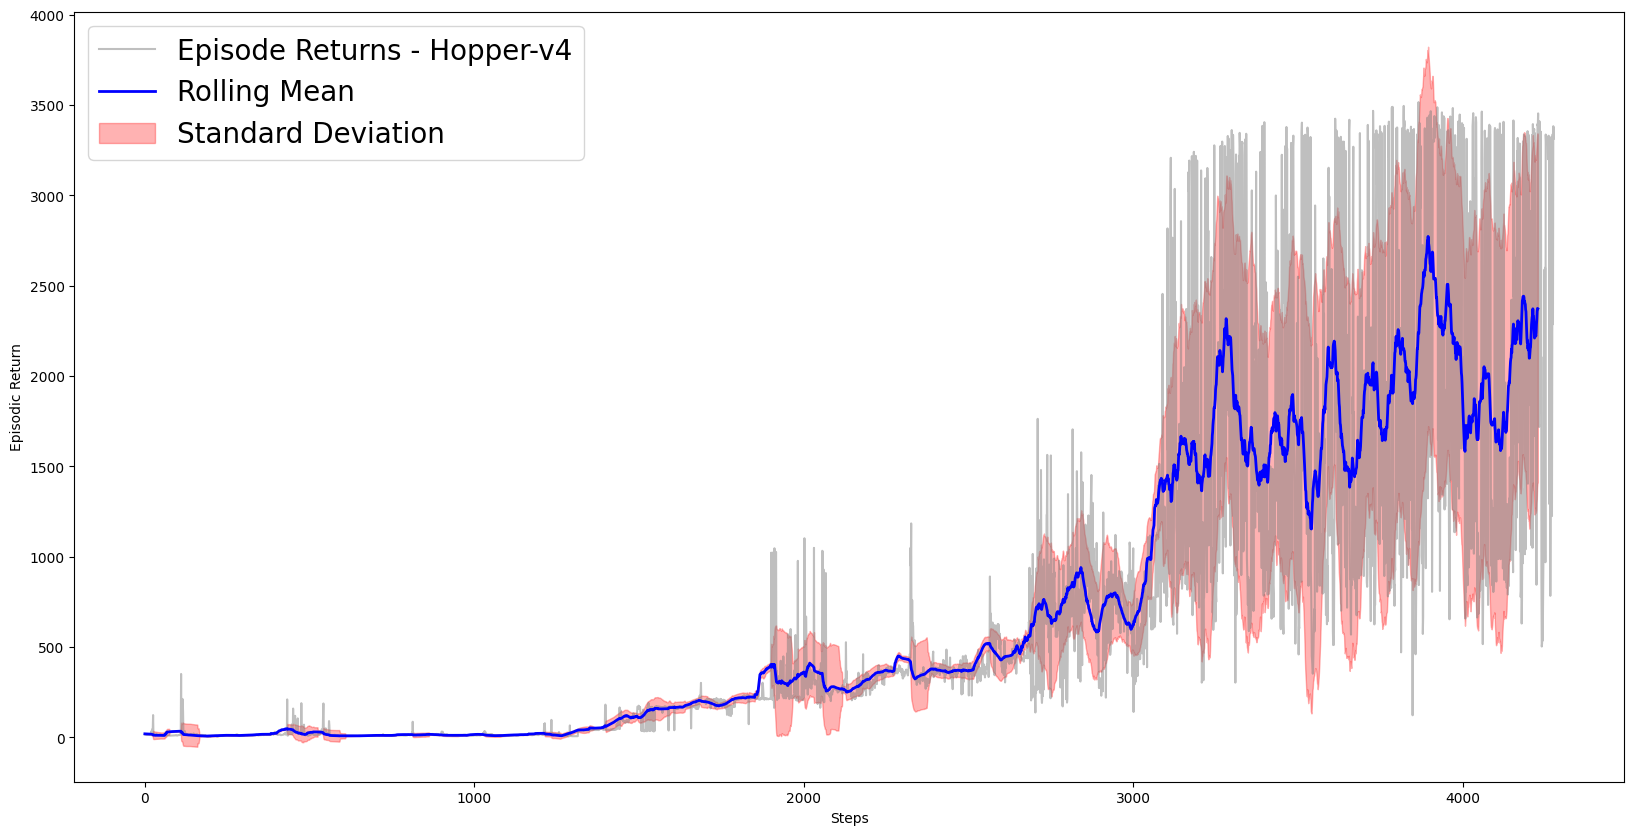

In [24]:
tmp_epi_rews = epi_rews[:len(epi_rews)-60]
import numpy as np
import matplotlib.pyplot as plt

# Compute the rolling mean and standard deviation
window = 50  # Window size for moving average
rolling_mean = np.convolve(tmp_epi_rews, np.ones(window)/window, mode='valid')

# Calculate the standard deviation with the same window
rolling_std = np.array([np.std(tmp_epi_rews[max(0, i - window + 1):i + 1]) for i in range(len(tmp_epi_rews))])
rolling_std = rolling_std[:len(rolling_mean)]  # Match lengths of rolling_mean and rolling_std

# Define the steps variable
steps = np.arange(len(tmp_epi_rews))

# Plot the results
plt.figure(figsize=(20, 10))

# Plot the entire episodic returns with a faded color
plt.plot(steps, tmp_epi_rews, label='Episode Returns - Hopper-v4', color='grey', alpha=0.5)

# Plot the rolling mean with a thicker line
plt.plot(steps[:len(rolling_mean)], rolling_mean, color='blue', linewidth=2, label='Rolling Mean')

# Plot the standard deviation as a filled area
plt.fill_between(steps[:len(rolling_mean)], rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.3, label='Standard Deviation')

plt.xlabel('Steps')
plt.ylabel('Episodic Return')
plt.legend(fontsize=20)
plt.show()
plt.close()

In [19]:
# 비디오 폴더 생성
video_folder = 'videos'
os.makedirs(video_folder, exist_ok=True)

# 비디오 녹화 및 저장
env = gym.make('Hopper-v4', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
total_reward = record_video(env, agent, video_folder)

print(f"Total reward: {total_reward}")


video_path = os.path.join(video_folder, 'rl-video-episode-0.mp4')
display(Video(video_path, embed=True))

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Total reward: 3435.2726151027687
